<a href="https://colab.research.google.com/github/Vaani03/Dogs-and-Cats-Classification/blob/main/dogs_vs_cats_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Downloading Dataset From Kaggle

In [ ]:
!pip install -q kaggle

In [ ]:
mkdir ~/.kaggle/

In [ ]:
cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c dogs-vs-cats

  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 32.3MB/s]
 98% 267M/271M [00:03<00:00, 93.0MB/s]
100% 271M/271M [00:03<00:00, 92.7MB/s]
 99% 538M/543M [00:05<00:00, 83.0MB/s]
100% 543M/543M [00:05<00:00, 100MB/s] 


In [ ]:
!unzip train.zip

In [ ]:
!unzip test1.zip

Libraries used:

In [ ]:
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

Image Properties:

In [ ]:
Image_Width=128
Image_Height=128
Image_Size=(Image_Width,Image_Height)
Image_Channels=3

Preparing Dataset For Training the Model

In [ ]:
filenames=os.listdir("/content/training/train")

categories=[]
for f_name in filenames:
    category=f_name.split('.')[0]
    if category=='dog':
        categories.append(1)
    else:
        categories.append(0)

df=pd.DataFrame({
    'filename':filenames,
    'category':categories
})

Adding Different Layers of CNN and creating a neural network model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dropout,Flatten,Dense,Activation,BatchNormalization

model=Sequential()

model.add(Conv2D(32,(3,3),activation='relu',input_shape=(Image_Width,Image_Height,Image_Channels)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2,activation='softmax'))


model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

Analyzing the model by summary of model

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 61, 61, 64)       2

Adding Early stopping for epochs and defining callbacks

In [ ]:
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(patience = 10)
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_acc',patience = 2,verbose = 1,factor = 0.5,min_lr = 0.00001)
callbacks = [earlystop, learning_rate_reduction]

Managing the Data

In [ ]:
df["category"] = df["category"].replace({0:'cat',1:'dog'})
train_df,validate_df = train_test_split(df,test_size=0.20, random_state=42)

train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

total_train=train_df.shape[0]
total_validate=validate_df.shape[0]
batch_size=15

Adding training and validation data generator

In [ ]:
train_datagen = ImageDataGenerator(rotation_range=15,
                                rescale=1./255,
                                shear_range=0.1,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                width_shift_range=0.1,
                                height_shift_range=0.1
                                )

train_generator = train_datagen.flow_from_directory("/content/training/",
                                                 target_size=Image_Size,
                                                 class_mode='categorical',
                                                 batch_size=batch_size, shuffle=False)

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory("/content/training/",
                                                 target_size=Image_Size,
                                                 class_mode='categorical',
                                                 batch_size=batch_size, shuffle=False)

test_datagen = ImageDataGenerator(rotation_range=15,
                                rescale=1./255,
                                shear_range=0.1,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                width_shift_range=0.1,
                                height_shift_range=0.1)

test_generator = test_datagen.flow_from_directory("/content/test/",
                                                 target_size=Image_Size,
                                                 class_mode='categorical',
                                                 batch_size=batch_size, shuffle=False)

Found 25000 images belonging to 1 classes.
Found 25000 images belonging to 1 classes.
Found 12500 images belonging to 1 classes.


Training the model by calculating the epochs

In [ ]:
epochs=10
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Saving the model

In [ ]:
model.save("model1_catsVSdogs_10epochs.h5")

Preparing the data for testing

In [ ]:
test_filenames = os.listdir("/content/test/test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

Making Categorical Predictions

In [ ]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


Converting labels to Categories

In [ ]:
test_df['category'] = np.argmax(predict, axis=-1)

label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)
test_df['category']=test_df.category.astype(object)
test_df['category'] = test_df['category'].replace({'dog': 1, 'cat': 0})

Visualizing the result of our prediction

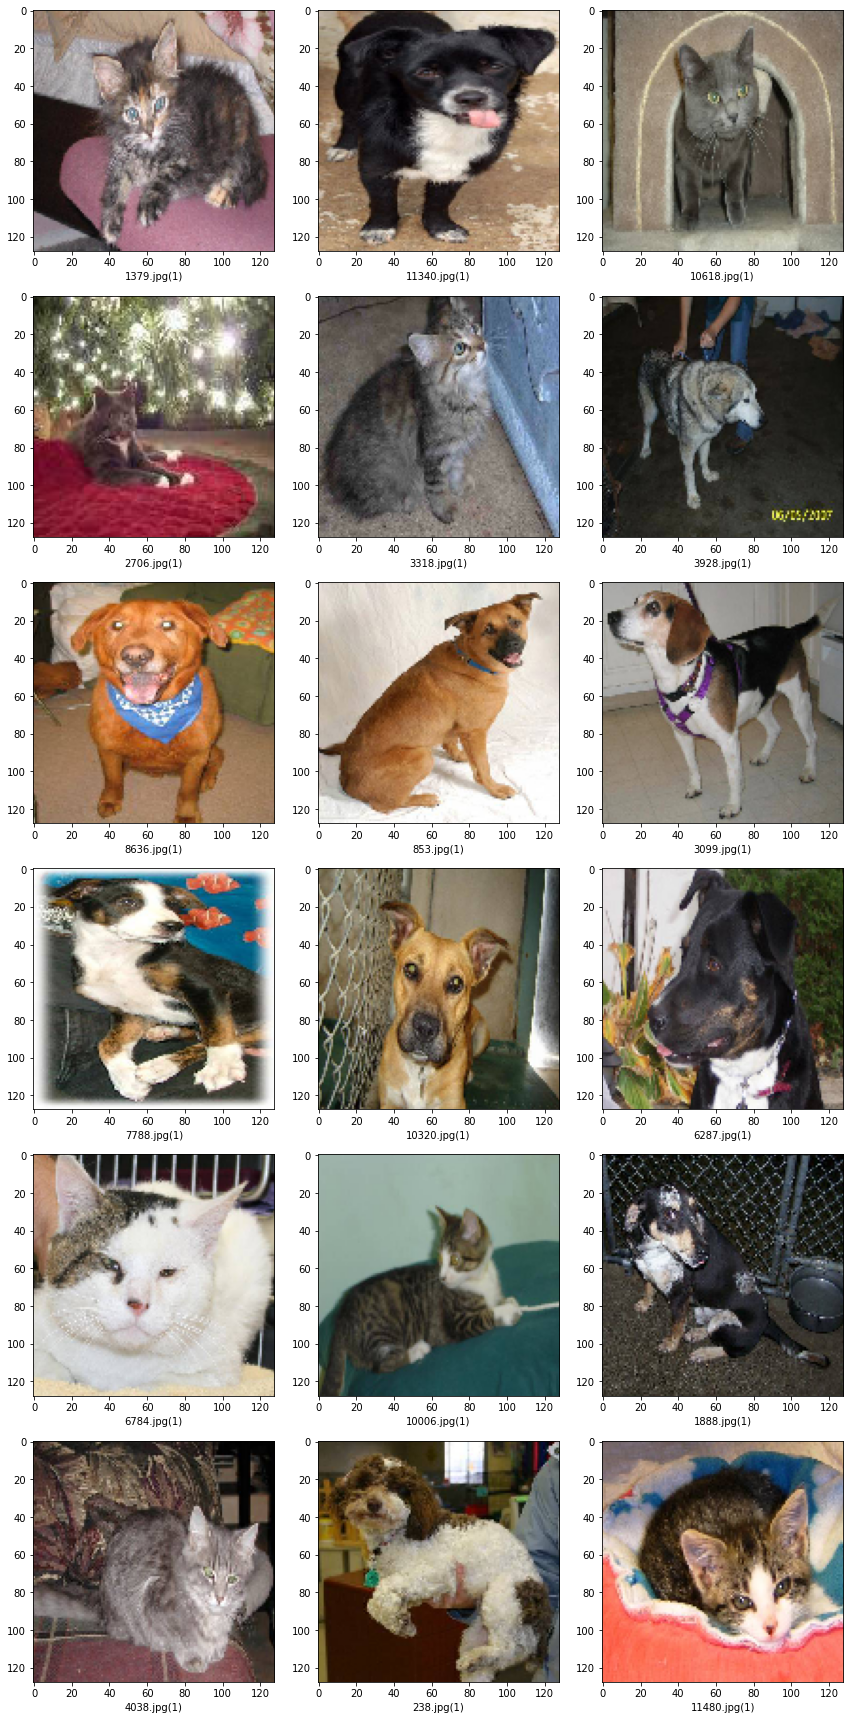

In [ ]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("/content/test/test1/"+filename, target_size=Image_Size)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

Testing the performance of our model on any custom image

In [ ]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model

def load_image(filename):
	# load the image
	img = load_img(filename, target_size=(128, 128))
	# convert to array
	img = img_to_array(img)
	# reshape into a single sample with 3 channels
	img = img.reshape(1, 128, 128, 3)
	# center pixel data
	img = img.astype('float32')
	img = img - [123.68, 116.779, 103.939]
	return img
 
# load an image and predict the class
def run_example():
	# load the image
	img = load_image('/content/test/test1/10000.jpg')
	# load model
	model = load_model('/content/model1_catsVSdogs_10epochs.h5')
	# predict the class
	result = model.predict(img)
	print(result[0].astype(int))
 
run_example()

[1 0]
